# 1. Предобработка данных

In [1]:
import sqlite3
import pandas as pd
import re
from re import search
import matplotlib.pyplot as plt
import pymorphy3
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from scipy import stats
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
dbfile = 'data/shop_database.db'
conn = sqlite3.connect(dbfile)
cursor = conn.cursor

In [3]:
conn = sqlite3.connect(dbfile)
cursor = conn.cursor
personal_data = pd.read_sql_query('SELECT *\
                        FROM personal_data\
                        WHERE country == 32',
                       conn)
conn.close()

In [4]:
personal_data[(personal_data['age']<17)&(personal_data['education']=='высшее')].shape[0]/personal_data.shape[0]

0.026963710494897843

Некорректные данные составляют менее 3 %. Удаляю их.

In [5]:
personal_data = personal_data[~((personal_data['age']<17)&(personal_data['education']=='высшее'))]

In [6]:
personal_data_2 = pd.read_csv('data/personal_data.csv')
personal_data_2 = personal_data_2[personal_data_2['country']==32]

In [7]:
personal_data_2[((personal_data_2['age']<17)&(personal_data_2['education']=='высшее'))].shape[0]/personal_data_2.shape[0]

0.02868826273081592

Некорректные данные составляют менее 3 %. Удаляю их.

In [8]:
personal_data_2 = personal_data_2[~((personal_data_2['age']<17)&(personal_data_2['education']=='высшее'))]

In [9]:
print(personal_data.shape)
print(personal_data_2.shape)

(86392, 6)
(15202, 5)


In [10]:
personal_data = pd.concat([personal_data, personal_data_2], ignore_index=True)

In [11]:
conn = sqlite3.connect(dbfile)
cursor = conn.cursor
personal_data_coeffs = pd.read_sql_query('SELECT id, personal_coef\
                        FROM personal_data_coeffs',
                       conn)
conn.close()

In [12]:
df = personal_data.merge(personal_data_coeffs, how='left', on='id')

In [13]:
conn = sqlite3.connect(dbfile)
cursor = conn.cursor
purchases = pd.read_sql_query('SELECT*\
                        FROM purchases',
                       conn)
conn.close()

In [14]:
df = df.merge(purchases, how='left', on='id')

In [15]:
def normalize_colours(colour_string):
    
    colour_mapping = {
        'черный': ['черный', 'карбон'],
        'белый': ['белый', 'молочный', 'кость', 'мел', 'перламутровый'],
        'синий': ['синий', 'сапфировый', 'петроль', 'черничный', 'ультрамарин',
                  'индиго', 'лазурный', 'виноградный', 'кобальтовый', 'сизый',
                 'шторм'],
        'серый': ['серый', 'графитовый', 'серебряный', 'стальной', 'хромовый',
                  'асфальтовый', 'серебристый', 'меланж', 'антрацит', 'металлик',
                 'дымчатый', 'графит', 'серебро', 'пепельный', 'хром',
                 'вереск', 'обсидиан', 'никель', 'антрацитовый', 'металлический',
                  'титаниум', 'гранитный', 'cеребряный', 'платиновый', 'оловянный'],
        'зеленый': ['зеленый', 'оливковый', 'салатовый', 'болотный', 'мятный',
                    'еловый', 'фисташковый', 'яблочный', 'хвойный', 'изумрудный',
                    'малахитовый', 'лаймовый', 'лайм', 'ментол', 'травяной',
                   'хамелеон', 'яблоко', 'авокадо', 'кедровый', 'джунгли'],
        'бежевый': ['бежевый', 'кремовый', 'нюд', 'пудровый', 'шампань',
                   'льняной', 'экрю', 'латте', 'нюдовый'],
        'красный': ['красный', 'бордовый', 'малиновый', 'вишневый', 'алый',
                    'клубника', 'бордо', 'рубиновый', 'бургунди'],
        'голубой': ['голубой', 'бирюзовый', 'морской', 'волна', 'небесный',
                    'васильковый', 'аквамарин', 'волны', 'циан'],
        'розовый': ['розовый', 'пионовый'],
        'желтый': ['желтый', 'золотистый', 'солнечный', 'песочный', 'золотой',
                   'персиковый', 'медовый', 'горчичный', 'лимонный', 'золото',
                  'персик', 'янтарный', 'латунный', 'кукурузный', 'вольт'],
        'мультицвет': ['мультицвет'],
        'оранжевый': ['оранжевый', 'коралловый', 'охра', 'лососевый', 'морковный',
                     'абрикосовый', 'медный', 'бронзовый', 'манго', 'коралл',
                     'глиняный'],
        'фиолетовый': ['фиолетовый', 'сиреневый', 'лавандовый', 'фуксия', 'баклажановый',
                       'орхидея', 'ирисовый', 'сливовый', 'лиловый', 'винный',
                      'пурпурный', 'фиалковый', 'ирис', 'ежевичный', 'ягодный'],
        'коричневый': ['коричневый', 'кофейный', 'терракотовый', 'ореховый', 'какао',
                      'каштановый', 'кирпичный'],
        'милитари': ['милитари', 'хаки', 'камуфляж', 'камуфляжный', 'камо']
    }
    
    if not colour_string or colour_string.strip() == '':
        return []
    
    colours = colour_string.split('/')
    
    normalized_colours = []
    for colour in colours:
        colour = colour.strip().lower().replace('ё', 'е').replace('e', 'е')
        
        if colour == 'сиинй':
            colour = 'синий'
        
        if len(re.split("[,.-]", colour)) > 1:
            colour = (re.split("[,.-]", colour))[-1]
            
        for main_colour, variants in colour_mapping.items():
            if colour in variants:
                colour = main_colour
                break
                
        if colour not in colour_mapping.keys():
            colour = 'другой'
                
        normalized_colours.append(colour)
        
    return normalized_colours

In [16]:
df['normalized_colour'] = df['colour'].apply(normalize_colours)

In [17]:
#Код использовался для создания colour_mapping
#exploded_colours = df['normalized_colour'].explode()
#
#colour_counts = exploded_colours.value_counts()
#
#print(colour_counts)

Из датафрейма видно, что для женских товаров product_sex = 0, для мужских товаров product_sex = 1.

In [18]:
def search_product_sex(text):
    text = text.strip().lower()
    if search('жен|берем', text):
        return 0
    elif search('муж', text):
        return 1
    elif search('девоч|мальч|детск|подростк', text):
        return 2
    else:
        return 3

In [19]:
df['product_sex_search'] = df['product'].apply(lambda x: search_product_sex(x))

In [20]:
df[(df['product_sex']!=df['product_sex_search'])]['product_sex'].unique()

array([nan,  0.])

In [21]:
df[(df['product_sex']!=df['product_sex_search']) & (df['product_sex']==0)]

,id,gender,age,education,city,country,personal_coef,product,colour,cost,product_sex,base_sale,dt,normalized_colour,product_sex_search
27808,7554,0.0,43,среднее,1175,32,0.5072,Протеин / Белковый коктейль для похудения / Fi...,белый/маджента,929,0.0,1,57,"[белый, другой]",3
723456,25104,NaN,35,среднее,1203,32,0.4304,Протеин / Белковый коктейль для похудения / Fi...,белый/маджента,929,0.0,1,58,"[белый, другой]",3


Только 2 значения не совпало с найденными.

In [22]:
df['product_sex'] = df['product_sex'].fillna(df['product_sex_search'])

In [23]:
df = df.astype({'product_sex': 'int64'})

In [24]:
df = df.drop(['country', 'product_sex_search'], axis=1)

In [25]:
morph = pymorphy3.MorphAnalyzer()

def extract_noun(text):
    words = text.split()
    for word in words:
        parsed = morph.parse(word)[0]
        if "NOUN" in parsed.tag:
            return word
    return words[0]

In [26]:
df['product_category'] = df['product'].apply(lambda x: extract_noun(x.strip().lower().replace(',', '')))

In [27]:
df['product_category'].nunique()

843

In [28]:
def grouping_of_products(product_string, full_product_string):
    
    product_string = product_string.replace('k', 'к')
    
    product_mapping = {
        'обувь': [
            'кроссовки', 'кеды', 'полуботинки', 'сандалии', 'шлепанцы', 'слипоны', 'ботинки', 'сабо', 'бутсы',
            'сапоги', 'балетки', 'тапочки', 'эспадрильи', 'туфли', 'велоботинки', 'боксерки', 'мокасины', 'борцовки',
            'чешки', 'сороконожки', 'велотуфли', 'шиповки'
        ],
        'одежда': [
            'брюки', 'легинсы', 'тайтсы', 'лосины', 'гамаши', 'леггинсы', 'брюки-самосбросы', 'футболка', 'футболки',
            'майка', 'топ', 'туника', 'платье', 'джерси', 'бра', 'шорты', 'велосипедки', 'юбка-шорты', 'бриджи',
            'велошорты', 'юбка', 'брюки-шорты', 'куртка', 'ветровка', 'пуховик', 'пальто', 'комбинезон', 'жилет',
            'анорак', 'олимпийка', 'дождевик', 'бомбер', 'накидка-дождевик', 'накидка', 'полукомбинезон', 'парка',
            'толстовка', 'худи', 'джемпер', 'свитшот', 'лонгслив', 'поло', 'рубашка', 'свитер', 'рашгард', 'термобелье',
            'костюм', 'комплект одежды', 'купальник', 'плавки', 'джаммеры', 'плавки-шорты', 'бикини', 'пончо',
            'гидрокостюм', 'кимоно', 'комплект мембранной одежды', 'топ-бра', 'куртка-анорак', 'велобриджи', 'боди',
            'форма', 'тайсы'
        ],
        'аксессуары': [
            'очки', 'повязка', 'шапка', 'бейсболка', 'бейсболки', 'бандана', 'балаклава', 'козырек', 'панама', 'кепка',
            'манишка', 'лиф', 'трусы', 'носки', 'гетры', 'гольфы', 'ремень', 'перчатки', 'варежки', 'гейтор', 'стельки',
            'шнурки', 'подпяточники', 'бафф', 'украшение', 'полотенце', 'маска', 'напульсник', 'напульсники',
            'наколенники', 'наколенник', 'налокотники', 'брелок', 'подушка', 'сидушка', 'вкладыш', 'плед', 'одеяло',
            'стрессбол', 'стрессбол', 'шнурок', 'браслет', 'шарф', 'повязки', 'шапка и перчатки', 'рукава', 'рукав',
            'ремень-держатель', 'ремни для рюкзака', 'полотенца', 'корпус', 'флаг', 'снуд', 'наклейки', 'тату-наклейки'
        ],
        'рюкзаки и сумки': [
            'рюкзак', 'рюкзаки', 'герморюкзак', 'рюкзак-жилет', 'сумка', 'мешок', 'гермомешок', 'гермосумка', 'кошелек',
            'несессер', 'сумка-шоппер', 'сумка-шопер', 'пакет', 'чехол', 'чехлы', 'пояс', 'чемодан', 'баул', 'сумка-баул',
            'защитные чехлы для обуви', 'станок', 'сумка-рюкзак', 'аптечка', 'гермочехол', 'фартук'
        ],
        'электроника': [
            'камера', 'фонарь', 'эхолот', 'фитнес-браслет', 'компьютер', 'велокомпьютер', 'весы', 'аккумулятор', 'часы',
            'монитор', 'батарейки', 'станция', 'наушники', 'фитнес', 'фонари', 'панель', 'шагомер', 'секундомер',
            'устройство', 'утюг'
        ],
        'туристические аксессуары': [
            'бутылка', 'фляжка', 'фляга', 'кружка', 'термокружка', 'флягодержатель', 'термос', 'термоконтейнер',
            'термобутылка', 'термосумка', 'нож', 'мультитул', 'ложка', 'миска', 'чайник', 'система', 'шейкер',
            'ремонтный комплект для матраса', 'бинокль', 'гамак', 'веревка', 'грелка', 'палатка', 'тент', 'матрас',
            'набор', 'кресло', 'стул', 'стул-табурет', 'кровать-раскладушка', 'плита', 'котел', 'котелок', 'кухня',
            'баллон','горелка', 'экран', 'топор', 'насос-помпа', 'карман', 'лопата', 'стол', 'москитная сетка', 'коврик',
            'душ-гермомешок', 'дуги', 'карабин', 'пила', 'тренога', 'переходник-адаптер', 'удилище', 'катушка', 'спиннинг',
            'воблер', 'леска', 'блесна', 'стул-рюкзак', 'мангал', 'мультиинструмент', 'спички', 'веревки-растяжки',
            'огниво', 'комплект радиостанций', 'стропа', 'матраc', 'переходник', 'фильтр', 'тарелка', 'кораблик',
            'комплект для питьевых систем', 'вставка', 'кровать', 'дно', 'стакан', 'палатка-тент', 'душ', 'шампуры',
            'кофеварка', 'пряжка', 'чашка', 'кастрюля', 'крюк', 'сухое', 'пуллер', 'бутылки', 'виброхвост', 'резак',
            'лампа', 'разогреватель', 'клапан', 'указка', 'насадки'
        ],
        'транспорт': [
            'байдарка', 'лодка', 'велосипед', 'самокат', 'электросамокат', 'электровелосипед', 'скейтборд', 'лонгборд',
            'коньки', 'круизер', 'мини-круизер', 'ролик', 'беговел', 'cамокат', 'сноуборд', 'лыжи', 'фитнес-коньки',
            'sup', 'доска', 'gladiator', 'катамаран', 'пакрафт', 'комплект лыжный', 'каяк', 'ролики'
        ],
        'спортивное питание, медицина, красота': [
            'батончик', 'протеин', 'мюсли', 'изотоник', 'аминокислоты', 'креатин', 'добавка', 'батончики', 'витамины',
            'печенье', 'казеин', 'коллаген', 'аминокислота', 'витамин', 'вода', 'напиток', 'комплекс', 'стик',
            'аэрозоль', 'аэрозоль-репеллент', 'крем', 'спрей охлаждающий', 'жиросжигатель', 'гейнер', 'суппорт',
            'кинезиотейп', 'массажер', 'тейп', 'магнезия', 'глюкозамин', 'л-карнитин', 'капсул', 'цилиндр', 'cуппорт',
            'магний', 'кислота/витамин', 'шар', 'мини-ролик', 'мелатонин', 'коктейль', 'лейкопластырь', 'пластырь'
        ],
        'аксессуары уходовые': [
            'сушка', 'краска-ликвид', 'краска', 'антифог', 'очиститель', 'пена', 'дезодорант', 'пропитка', 'средство',
            'гель', 'салфетки', 'салфетка', 'щетка', 'растяжитель', 'водоотталкивающий', 'водоотталкивающий спрей',
            'нейтрализатор', 'ластик', 'пятновыводитель'
        ],
        'велозапчасти': [
            'покрышка', 'колесо', 'велопедали', 'седло', 'держатель', 'вилка', 'замок', 'подножка', 'крыло',
            'звонок', 'смазка', 'мультиключ', 'грипсы', 'багажник', 'ручки', 'колодки', 'корзина',
            'переключатель', 'вынос', 'педали', 'втулка', 'каретка', 'тормоз', 'рога', 'штырь', 'зеркало', 'руль',
            'подшипник', 'цепь', 'выжимка', 'машинка', 'гудок', 'ключ', 'комборучка', 'щетка-скребок', 'крюк-держатель',
            'комборучки', 'трещотка', 'шампунь', 'комплект монтажек', 'защита', 'велокресло', 'велостанок',
            'ремонтный комплект', 'колпачки', 'тросики', 'заплатки', 'колеса', 'подставка для транспорта',
            'тормозная ручка', 'ручка для самоката', 'адаптер', 'шифтер', 'колодка', 'бушинги', 'сиденье',
            'гидролиния', 'самоката'
        ],
        'тренажеры': [
            'тренажер', 'велотренажер', 'дорожка', 'стойка', 'турник', 'скамья', 'мини-степпер', 'центр',
            'мини-велотренажер', 'степпер', 'спортивный комплекс', 'стойки', 'мини-тренажер', 'велоэргометр'
        ],
        'тренировочный инвентарь': [
            'мяч', 'мячи', 'ворота', 'бассейн', 'груша', 'кольцо', 'игра', 'ракетка', 'дротики', 'мишень', 'хоккей',
            'мини-набор', 'волан', 'воланы', 'дартс', 'фрисби', 'фишки', 'бейсбольная', 'барьер', 'теннисный стол',
            'трос', 'гантель', 'лента', 'эспандер', 'скакалка', 'платформа', 'гиря', 'утяжелители', 'гриф', 'диск',
            'блин', 'палки', 'мат', 'батут', 'обруч', 'брусья', 'медицинбол', 'баланс', 'петли', 'степ-платформа',
            'эспандеры', 'бодибар', 'коврик для фитнеса', 'эспандер-лента', 'колобашка', 'полусфера', 'нунчаки',
            'кольца гимнастические', 'тарелки-ловушки', 'шайба', 'гантели', 'канат', 'футбол', 'бассеин', 'насадка',
            'бумеранг', 'лестница', 'кольца гимнастические'
        ],
        'аксессуары для спорта': [
            'шапочка', 'ласты', 'шлем', 'клюшка', 'крепления', 'крепление', 'мазь', 'лыжероллеры', 'наконечники',
            'бинты', 'капа', 'бинт', 'шингарты', 'лапа', 'макивара', 'зажим','беруши', 'весло', 'трубка', 'лопатки',
            'нарукавники', 'матрац', 'насос', 'щитки', 'намотка', 'струна', 'виброгаситель', 'накладка', 'основание',
            'щит', 'свисток', 'игла', 'нагрудник', 'сетка', 'упоры', 'костюм-сауна', 'замки', 'блок', 'кардиопояс',
            'комплект для плавания', 'туба', 'утяжелитель', 'темляки', 'комплект защиты', 'шлем и маска', 'накладки',
            'кольца (аксессуары для спорта)', 'подставка для йоги', 'ручка для силового троса', 'комплект слайдеров',
            'ручка затягивания шнурков', 'ручка для лыжных палок', 'ремни для тяги', 'комплект крепежа', 'наконечник',
            'расширители', 'манжеты', 'круг', 'веломаска', 'связки', 'мини-ракетка', 'манометр', 'манжета', 'cмазка',
            'хвостовики', 'оголовник', 'футляр', 'команда', 'крюки', 'шкурка'
        ]
    }
    
    #В product_category == 'мальчиков' попали строки, где product in ['худи', 'лонгслив', 'поло'].
    #В product_category == 'девочек' попали строки, где product == 'худи'.
    #В product_category == 'оверсайз' попали строки, где product == 'худи'.
    
    if product_string in ['мальчиков', 'девочек', 'оверсайз']:
        product_string = 'худи'
    
    #В product_category == 'кг' попали строки, где product == 'блин'.
    if product_string == 'кг':
        product_string = 'блин'
    
    #В product_category == '335х83х15см' попали строки, где product == 'sup'.
    if product_string == '335х83х15см':
        product_string = 'sup'
        
    #В product_category == 'мл' попали строки, где product == 'спрей охлаждающий'.
    if product_string == 'мл':
        product_string = 'спрей охлаждающий'
        
    #В product_category == 'обуви' попали строки, где product == 'водоотталкивающий спрей'.
    if product_string == 'обуви':
        product_string = 'водоотталкивающий спрей'
        
    if product_string == 'веткровка':
        product_string = 'ветровка'
    
    if product_string == 'фитнеса':
        product_string = 'поло'
    
    if product_string == 'стол':
        if search('Теннисный', full_product_string):
            product_string = 'теннисный стол'
        
    if product_string == 'сетка':
        if search('Москитная', full_product_string): 
            product_string = 'москитная сетка'
        
    if product_string == 'комплекс':
        if search('Детский спортивный комплекс', full_product_string):
            product_string = 'спортивный комплекс'
        
    if product_string == 'коврик':
        if search('Коврик для фитнеса|Коврик для йоги', full_product_string):
            product_string = 'коврик для фитнеса'
        
    if product_string == 'комплект':
        if search('Комплект термобелья', full_product_string):
            product_string = 'термобелье'
        elif search('Комплект наборных гантелей', full_product_string):
            product_string = 'гантель'
        elif search('Ремонтный комплект Intex', full_product_string):
            product_string = 'ремонтный комплект для матраса'
        elif search('формы', full_product_string):
            product_string = 'комплект одежды'
        elif search('Комплект монтажек', full_product_string):
            product_string = 'комплект монтажек'
        elif search('Комплект лыжный', full_product_string):
            product_string = 'комплект лыжный'
        elif search('Комплект для плавания|маска, трубка', full_product_string):
            product_string = 'комплект для плавания'
        elif search('Комплект мембранной одежды|Комплект одежды', full_product_string):
            product_string = 'комплект мембранной одежды'
        elif search('Ремонтный комплект|Ремонтный велосипедный комплект', full_product_string):
            product_string = 'ремонтный комплект'
        elif search('Комплект защиты детский', full_product_string):
            product_string = 'комплект защиты'
        elif search('радиостанций', full_product_string):
            product_string = 'комплект радиостанций'
        elif search('Комплект лонгборд', full_product_string):
            product_string = 'лонгборд'
        elif search('Комплект шайб', full_product_string):
            product_string = 'шайба'
        elif search('Комплект скейтборд', full_product_string):
            product_string = 'скейтборд'
        elif search('Комплект детский шлем+маска', full_product_string):
            product_string = 'шлем и маска'
        elif search('Комплект детский Nike', full_product_string):
            product_string = 'шапка и перчатки'
        elif search('Комплект винтов и шайб', full_product_string):
            product_string = 'комплект крепежа'
        elif search('Комплект слайдеров', full_product_string):
            product_string = 'комплект слайдеров'
        elif search('Комплект Source', full_product_string):
            product_string = 'комплект для питьевых систем'
        elif search('Комплект датчика и модуля', full_product_string):
            product_string = 'электроника'
        elif search('Комплект ворот|Комплект мячей для настольного|Комплект запасных игроков', full_product_string):
            product_string = 'аксессуары для спорта'
        elif search('Комплект защитных чехлов для обуви', full_product_string):
            product_string = 'защитные чехлы для обуви'
        elif search('Комплект колес', full_product_string):
            product_string = 'колеса'
            
    if product_string == 'кольца':
        if search('Кольца гимнастические|Кольца навесные', full_product_string):
            product_string = 'кольца гимнастические'
        elif search('Кольца для треккинговых палок|Кольца для горнолыжных палок', full_product_string):
            product_string = 'кольца (аксессуары для спорта)'
            
    if product_string == 'подставка':
        if search('Подставка для ребенка на самокат|Напольная подставка для велосипеда', full_product_string):
            product_string = 'подставка для транспорта'
        elif search('Подставка для йоги', full_product_string):
            product_string = 'подставка для йоги'
            
    if product_string == 'ручка':
        if search('силового троса', full_product_string):
            product_string = 'ручка для силового троса'
        elif search('тормозная ручка', full_product_string):
            product_string = 'тормозная ручка'
        elif search('Ручка затягивания шнурков', full_product_string):
            product_string = 'ручка затягивания шнурков'
        elif search('Ручка для самоката', full_product_string):
            product_string = 'ручка для самоката'
        elif search('Ручка для лыжных палок', full_product_string):
            product_string = 'ручка для лыжных палок'
    
    if product_string == 'ремни':
        if search('Ремни для тяги', full_product_string):
            product_string = 'ремни для тяги'
        elif search('Ремни с пряжками', full_product_string):
            product_string = 'ремни для рюкзака'
            
    if product_string == 'стяжка':
        if search('Стяжка для крепления грузов', full_product_string):
            product_string = 'велозапчасти'
        elif search('Грудная стяжка', full_product_string):
            product_string = 'аксессуары для спорта'
            
    for category, variants in product_mapping.items():
        if product_string in variants:
            product_string = category
            break
            
    if product_string not in product_mapping.keys():
            product_string = 'другой'
        
    return product_string

In [29]:
df['product_category'] = df.apply(lambda x: grouping_of_products(x['product_category'],x['product']), axis=1)

In [30]:
df.product_category.value_counts()

product_category
одежда                                   293448
обувь                                    243895
аксессуары                                57154
туристические аксессуары                  41049
рюкзаки и сумки                           35172
транспорт                                 29774
тренировочный инвентарь                   20055
велозапчасти                              12007
аксессуары для спорта                     10646
тренажеры                                  4958
спортивное питание, медицина, красота      4416
электроника                                4406
аксессуары уходовые                        2713
другой                                     1878
Name: count, dtype: int64

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761571 entries, 0 to 761570
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 761571 non-null  int64  
 1   gender             649198 non-null  float64
 2   age                761571 non-null  int64  
 3   education          761571 non-null  object 
 4   city               761571 non-null  int64  
 5   personal_coef      761571 non-null  float64
 6   product            761571 non-null  object 
 7   colour             644436 non-null  object 
 8   cost               761571 non-null  int64  
 9   product_sex        761571 non-null  int64  
 10  base_sale          761571 non-null  int64  
 11  dt                 761571 non-null  int64  
 12  normalized_colour  761571 non-null  object 
 13  product_category   761571 non-null  object 
dtypes: float64(2), int64(7), object(5)
memory usage: 81.3+ MB


# 2. Бинарная классификация

In [32]:
mlb = MultiLabelBinarizer()
colour_encoded = pd.DataFrame(
    mlb.fit_transform(df['normalized_colour']),
    columns=mlb.classes_,
    index=df.index
)

In [33]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
product_category_encoded = pd.DataFrame(
    ohe.fit_transform(df[['product_category']]),
    columns=ohe.get_feature_names_out(['product_category']),
    index=df.index
)

In [34]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
product_sex_encoded = pd.DataFrame(
    ohe.fit_transform(df[['product_sex']]),
    columns=ohe.get_feature_names_out(['product_sex']),
    index=df.index
)

In [35]:
education_encoded = df['education'].map({'среднее': 0, 'высшее': 1})

In [36]:
df_processed = pd.concat([
    df.drop(columns=['colour', 'normalized_colour', 'product', 'product_category', 'product_sex', 'education']),
    colour_encoded,
    product_category_encoded,
    product_sex_encoded,
    education_encoded
], axis=1)

In [37]:
df_known = df_processed[df_processed['gender'].notna()]
df_unknown = df_processed[df_processed['gender'].isna()]

In [38]:
X = df_known.drop(columns=['gender', 'id'])
y = df_known['gender']
X_to_predict = df_unknown.drop(columns=['gender', 'id'])

In [39]:
numeric_features = ['age', 'cost']

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

In [41]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        class_weight='balanced'
    ))
])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [43]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'cost'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        n_estimators=200, random_state=42))])

In [44]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57955
         1.0       1.00      1.00      1.00     71885

    accuracy                           1.00    129840
   macro avg       1.00      1.00      1.00    129840
weighted avg       1.00      1.00      1.00    129840



In [45]:
#from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'classifier__n_estimators': [50, 100, 200],
#    'classifier__max_depth': [None, 10, 20],
#    'classifier__random_state': [42],
#    'classifier__class_weight': ['balanced']
#}

#grid_search = GridSearchCV(model, param_grid, cv=3, scoring = 'f1_weighted')
#grid_search.fit(X_train, y_train)
#print(f'Лучшие параметры: {grid_search.best_params_}')

Лучшие параметры: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__n_estimators': 200, 'classifier__random_state': 42}

In [46]:
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=0.01,
        penalty='l1',
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    ))
])

In [47]:
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'cost'])])),
                ('classifier',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [48]:
y_pred_logistic = logistic_pipeline.predict(X_test)
y_proba_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

In [49]:
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logistic))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_proba_logistic))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     57955
         1.0       0.98      1.00      0.99     71885

    accuracy                           0.99    129840
   macro avg       0.99      0.99      0.99    129840
weighted avg       0.99      0.99      0.99    129840


ROC-AUC Score: 0.9776191044411269


In [50]:
#param_grid = {
#    'classifier__C': [0.01, 0.1, 1, 10],
#    'classifier__penalty': ['l1', 'l2'],
#    'classifier__random_state': [42],
#    'classifier__class_weight': ['balanced'],
#    'classifier__max_iter': [1000],
#    'classifier__solver': ['liblinear', 'saga']
#}

#logistic_grid = GridSearchCV(logistic_pipeline, param_grid, cv=3, scoring = 'f1_weighted')
#logistic_grid.fit(X_train, y_train)
#print(f'Лучшие параметры: {logistic_grid.best_params_}')

Лучшие параметры: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__random_state': 42, 'classifier__solver': 'liblinear'}

In [51]:
print('RandomForest F1:', f1_score(y_test, y_pred, average='weighted'))
print('LogisticRegression F1:', f1_score(y_test, y_pred_logistic, average='weighted'))

RandomForest F1: 1.0
LogisticRegression F1: 0.9896282954656952


RandomForest показал лучше результат. В качестве модели классификации оставляю его.

In [52]:
predicted_genders = model.predict(X_to_predict)

In [53]:
df.loc[df['gender'].isna(), 'gender'] = predicted_genders

In [54]:
print(f'Количество пропусков после заполнения: {df.gender.isna().sum()}')

Количество пропусков после заполнения: 0


In [55]:
df.to_csv('data/full_data.csv', index=False) 

# 3. A/B-тестирование

In [56]:
def load_ids_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()[1:]
    
        all_ids = []
        for line in lines:
    
            line = line.strip()
            if not line:
                continue
        
            ids_in_line = line.replace(';', ',').split(',')
    
            for i in ids_in_line:
                i = i.strip()
                if i.isdigit():
                    all_ids.append(int(i))
    
    return list(set(all_ids))

In [57]:
positive_ids = load_ids_from_file('data/ids_first_company_positive.txt')

In [58]:
print(len(positive_ids))

2488


In [59]:
negative_ids = load_ids_from_file('data/ids_first_company_negative.txt')

In [60]:
print(len(negative_ids))

2660


In [61]:
common_ids = list(set(positive_ids)&set(negative_ids))
positive_ids = [i for i in positive_ids if i not in common_ids]
negative_ids = [i for i in negative_ids if i not in common_ids]

In [62]:
df_ab = df[(df['dt']>=5) & (df['dt']<=16)]

In [63]:
def group_definition(id):
    if id in positive_ids:
        group = 'test'
    elif id in negative_ids:
        group = 'control'
    else:
        group = 'not enter'
    return group

In [64]:
df_ab['group'] = df_ab['id'].apply(lambda x: group_definition(x))

C:\Users\LEGION\AppData\Local\Temp\ipykernel_31868\1429475216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ab['group'] = df_ab['id'].apply(lambda x: group_definition(x))


In [65]:
df_ab = df_ab[df_ab['group']!='not enter']

## Конверсия в покупку

In [66]:
ab_cr = df_ab.groupby('group').id.nunique().reset_index()
ab_cr['all_id'] = [len(negative_ids), len(positive_ids)]
ab_cr['CR'] = round(ab_cr['id']/ab_cr['all_id']*100, 1)

In [67]:
ab_cr

,group,id,all_id,CR
0,control,2555,2657,96.2
1,test,2300,2485,92.6


Н0: Конверсия в тестовой и контрольной группах одинакова.\
Н1: Конверсия в тестовой группе ниже, чем в контрольной.\
Для проверки гипотезы использую биномиальный критерий.

In [68]:
def binom_test(n1, m1, n2, m2, alternative, alpha = 0.05):

    T = (m1/n1-m2/n2)/((m1+m2)/(n1+n2)*(1-(m1+m2)/(n1+n2))*(1/n1+1/n2))**0.5

    if alternative == 'ниже':
        P = stats.norm.cdf(T)
        print('Критическая область - значения статистики менее ',round(stats.norm.ppf(alpha), 2))
    elif alternative == 'выше':
        P = 1 - stats.norm.cdf(T)
        print('Критическая область - значения статистики выше ',round(stats.norm.ppf(1 - alpha), 2))
    else:
        P = min(2*stats.norm.cdf(T), 2-2*stats.norm.cdf(T))
        print('Критическая область - значения статистики менее ',round(stats.norm.ppf(alpha/2), 2))
        print('Критическая область - значения статистики выше ',round(stats.norm.ppf(1 - alpha/2), 2))
    
    print('Statistic: ', T, ', p-value: ', round(P, 2))

In [69]:
binom_test(n1 = ab_cr.loc[1, 'all_id'],
           m1 = ab_cr.loc[1, 'id'],
           n2 = ab_cr.loc[0, 'all_id'],
           m2  = ab_cr.loc[0, 'id'],
           alternative = 'ниже')

Критическая область - значения статистики менее  -1.64
Statistic:  -5.628404348815373 , p-value:  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - Конверсия в тестовой группе ниже, чем в контрольной.

In [70]:
def category_cost(cost):
    if cost < 5000:
        return 'низкая'
    elif cost < 50000:
        return 'средняя'
    else:
        return 'высокая'

df_ab['category_cost'] = df_ab['cost'].apply(category_cost)

In [71]:
ab_cr_category_cost = df_ab.groupby(['group', 'category_cost']).id.nunique().reset_index()
ab_cr_category_cost['all_id'] = ab_cr_category_cost['group'].apply(lambda x: len(negative_ids) if x == 'control'
                                                                   else len(positive_ids))

In [72]:
ab_cr_category_cost['CR'] = round(ab_cr_category_cost['id']/ab_cr_category_cost['all_id']*100, 1)

In [73]:
ab_cr_category_cost

,group,category_cost,id,all_id,CR
0,control,высокая,69,2657,2.6
1,control,низкая,2136,2657,80.4
2,control,средняя,1383,2657,52.1
3,test,высокая,55,2485,2.2
4,test,низкая,2071,2485,83.3
5,test,средняя,1414,2485,56.9


Н0: Конверсия в тестовой и контрольной группах одинакова (для товаров с низкой стоимостью).\
Н1: Конверсия в тестовой группе выше, чем в контрольной (для товаров с низкой стоимостью).\
Для проверки гипотезы использую биномиальный критерий.

In [74]:
binom_test(n1 = ab_cr_category_cost.loc[4, 'all_id'],
           m1 = ab_cr_category_cost.loc[4, 'id'],
           n2 = ab_cr_category_cost.loc[1, 'all_id'],
           m2  = ab_cr_category_cost.loc[1, 'id'],
           alternative = 'выше')

Критическая область - значения статистики выше  1.64
Statistic:  2.7393779390206285 , p-value:  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - конверсия в тестовой группе выше, чем в контрольной (для товаров с низкой стоимостью).

Н0: Конверсия в тестовой и контрольной группах одинакова (для товаров со средней стоимостью).\
Н1: Конверсия в тестовой группе выше, чем в контрольной (для товаров со средней стоимостью).\
Для проверки гипотезы использую биномиальный критерий.

In [75]:
binom_test(n1 = ab_cr_category_cost.loc[5, 'all_id'],
           m1 = ab_cr_category_cost.loc[5, 'id'],
           n2 = ab_cr_category_cost.loc[2, 'all_id'],
           m2  = ab_cr_category_cost.loc[2, 'id'],
           alternative = 'выше')

Критическая область - значения статистики выше  1.64
Statistic:  3.489546992882526 , p-value:  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - конверсия в тестовой группе выше, чем в контрольной (для товаров с низкой стоимостью).

Н0: Конверсия в тестовой и контрольной группах одинакова (для товаров с высокой стоимостью).\
Н1: Конверсия в тестовой группе ниже, чем в контрольной (для товаров с высокой стоимостью).\
Для проверки гипотезы использую биномиальный критерий.

In [76]:
binom_test(n1 = ab_cr_category_cost.loc[3, 'all_id'],
           m1 = ab_cr_category_cost.loc[3, 'id'],
           n2 = ab_cr_category_cost.loc[0, 'all_id'],
           m2  = ab_cr_category_cost.loc[0, 'id'],
           alternative = 'ниже')

Критическая область - значения статистики менее  -1.64
Statistic:  -0.8961198162067691 , p-value:  0.19


Значение статистики находится в доверительной области. P-value больше 0.05, соответственно принимаем нулевую гипотезу конверсия в тестовой и контрольной группах одинакова (для товаров с высокой стоимостью).

## Средняя выручка на одного пользователя (ARPU)

In [77]:
test = df_ab[df_ab['group'] == 'test'].groupby('id').cost.sum().reset_index()
test2 = pd.DataFrame(data = list(set(positive_ids) - set(test['id'])), columns = ['id'])
test2['cost'] = 0
test = pd.concat([test, test2], ignore_index=True)

In [78]:
control = df_ab[df_ab['group'] == 'control'].groupby('id').cost.sum().reset_index()
control2 = pd.DataFrame(data = list(set(negative_ids) - set(control['id'])), columns = ['id'])
control2['cost'] = 0
control = pd.concat([control, control2], ignore_index=True)

In [79]:
print('Средняя выручка на одного пользователя (ARPU) в тестовой выборке: ', round(test['cost'].mean()))
print('Средняя выручка на одного пользователя (ARPU) в контрольной выборке: ', round(control['cost'].mean()))

Средняя выручка на одного пользователя (ARPU) в тестовой выборке:  24894
Средняя выручка на одного пользователя (ARPU) в контрольной выборке:  21449


Н0: Выборка подчиняется нормальному распределению.\
Н1: Выборка не подчиняется нормальному распределению.

In [80]:
def test_for_normality(sample):
    shapiro_test = stats.shapiro(sample)
    if shapiro_test.pvalue > 0.05:
        print('Выборка подчиняется нормальному распределению.')
    else:
        print('Выборка не подчиняется нормальному распределению.')

In [81]:
test_for_normality(test['cost'])

Выборка не подчиняется нормальному распределению.


In [82]:
test_for_normality(control['cost'])

Выборка не подчиняется нормальному распределению.


Тестовая и контрольные выборки не подчиняются нормальному распределению, значит для проверки гипотезы о равенстве средних для независимых выборок использую критерий Манна-Уитни-Уилкоксона.

Н0: Средняя выручка на одного пользователя в тестовой и контрольной группах одинакова.\
Н1: Средняя выручка на одного пользователя в тестовой группе выше, чем в контрольной.\
Для проверки гипотезы использую критерий Манна-Уитни-Уилкоксона.

In [83]:
def Mann_Whitney_U_test(sample1, sample2, alpha=0.05, alternative = 'greater'):
    
    n1 = len(sample1)
    n2 = len(sample2)
    mu_U = n1*n2/2
    sigma_U = np.sqrt(n1*n2*(n1+n2+1)/12)
    
    if alternative == 'greater':
        result_count = stats.mannwhitneyu(sample1, sample2, alternative = 'greater')
        z_critical = stats.norm.ppf(1-alpha)
        U_critical = mu_U + z_critical*sigma_U
        print('Критическая область - значения статистики выше ', round(U_critical))
        
    elif alternative == 'less':
        result_count = stats.mannwhitneyu(sample1, sample2, alternative = 'less')
        z_critical = stats.norm.ppf(alpha)
        U_critical = mu_U + z_critical*sigma_U
        print('Критическая область - значения статистики ниже ', round(U_critical))
        
    else:
        result_count = stats.mannwhitneyu(sample1, sample2, alternative = 'two-sided')
        z_critical_lower = stats.norm.ppf(alpha/2)
        z_critical_upper = stats.norm.ppf(1-alpha/2)
        U_critical_lower = mu_U + z_critical_lower*sigma_U
        U_critical_upper = mu_U + z_critical_upper*sigma_U
        print('Критическая область - значения статистики ниже ', round(U_critical_lower))
        print('Критическая область - значения статистики выше ', round(U_critical_upper))
    
    print('Статистика: ', result_count.statistic)
    
    if result_count.pvalue < alpha:
        print('P-value меньше 0.05 и составляет ', round(result_count.pvalue, 2))
    else:
        print('P-value больше 0.05 и составляет ', round(result_count.pvalue, 2))

In [84]:
Mann_Whitney_U_test(test['cost'], control['cost'])

Критическая область - значения статистики выше  3388822
Статистика:  3605962.0
P-value меньше 0.05 и составляет  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - Средняя выручка на одного пользователя (ARPU) в тестовой группе выше, чем в контрольной.

## Средняя выручка на одного покупателя (ARPPU)

In [85]:
test_arppu = df_ab[df_ab['group'] == 'test'].groupby('id').cost.sum().reset_index()

In [86]:
control_arppu = df_ab[df_ab['group'] == 'control'].groupby('id').cost.sum().reset_index()

In [87]:
print('Средняя выручка на одного покупателя (ARPPU) в тестовой выборке: ', round(test_arppu['cost'].mean()))
print('Средняя выручка на одного покупателя (ARPPU) в контрольной выборке: ', round(control_arppu['cost'].mean()))

Средняя выручка на одного покупателя (ARPPU) в тестовой выборке:  26896
Средняя выручка на одного покупателя (ARPPU) в контрольной выборке:  22305


Н0: Выборка подчиняется нормальному распределению.\
Н1: Выборка не подчиняется нормальному распределению.

In [88]:
test_for_normality(test_arppu['cost'])

Выборка не подчиняется нормальному распределению.


In [89]:
test_for_normality(control_arppu['cost'])

Выборка не подчиняется нормальному распределению.


Тестовая и контрольные выборки не подчиняются нормальному распределению, значит для проверки гипотезы о равенстве средних для независимых выборок использую критерий Манна-Уитни-Уилкоксона.

Н0: Средняя выручка на одного покупателя в тестовой и контрольной группах одинакова.\
Н1: Средняя выручка на одного покупателя в тестовой группе выше, чем в контрольной.\
Для проверки гипотезы использую критерий Манна-Уитни-Уилкоксона.

In [90]:
Mann_Whitney_U_test(test_arppu['cost'], control_arppu['cost'])

Критическая область - значения статистики выше  3018461
Статистика:  3361927.0
P-value меньше 0.05 и составляет  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - Средняя выручка на одного покупателя (ARPPU) в тестовой группе выше, чем в контрольной.

## Средний чек

In [91]:
test_cheque = df_ab[df_ab['group'] == 'test'].groupby(by=['id']).agg({'cost':'sum','dt':'nunique'}).reset_index()
test_cheque['avg_cheque'] = round(test_cheque['cost']/test_cheque['dt'], 2)
control_cheque = df_ab[df_ab['group'] == 'control'].groupby(by=['id']).agg({'cost':'sum','dt':'nunique'}).reset_index()
control_cheque['avg_cheque'] = round(control_cheque['cost']/control_cheque['dt'], 2)

In [92]:
print('Средний чек в тестовой выборке: ', round(test_cheque['avg_cheque'].mean(), 2))
print('Средний чек в контрольной выборке: ', round(control_cheque['avg_cheque'].mean(), 2))

Средний чек в тестовой выборке:  10069.83
Средний чек в контрольной выборке:  9286.9


In [93]:
test_for_normality(test_cheque['avg_cheque'])

Выборка не подчиняется нормальному распределению.


In [94]:
test_for_normality(control_cheque['avg_cheque'])

Выборка не подчиняется нормальному распределению.


Тестовая и контрольные выборки не подчиняются нормальному распределению, значит для проверки гипотезы о равенстве средних для независимых выборок использую критерий Манна-Уитни-Уилкоксона.

Н0: Средний чек в тестовой и контрольной группах одинаков.\
Н1: Средний чек в тестовой группе выше, чем в контрольной.\
Для проверки гипотезы использую критерий Манна-Уитни-Уилкоксона.

In [95]:
Mann_Whitney_U_test(test_cheque['avg_cheque'], control_cheque['avg_cheque'])

Критическая область - значения статистики выше  3018461
Статистика:  3205376.5
P-value меньше 0.05 и составляет  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - средний чек в тестовой группе выше, чем в контрольной.

## Количество покупок на пользователя

In [96]:
test_count = df_ab[df_ab['group'] == 'test'].groupby('id').product.count().reset_index()
test_count_2 = pd.DataFrame(data = list(set(positive_ids) - set(test_count['id'])), columns = ['id'])
test_count_2['product'] = 0
test_count = pd.concat([test_count, test_count_2], ignore_index=True)

control_count = df_ab[df_ab['group'] == 'control'].groupby('id').product.count().reset_index()
control_count_2 = pd.DataFrame(data = list(set(negative_ids) - set(control_count['id'])), columns = ['id'])
control_count_2['product'] = 0
control_count = pd.concat([control_count, control_count_2], ignore_index=True)

In [97]:
print('Среднее количество покупок на пользователя в тестовой выборке: ', round(test_count['product'].mean()))
print('Среднее количество покупок на пользователя в контрольной выборке: ', round(control_count['product'].mean()))

Среднее количество покупок на пользователя в тестовой выборке:  5
Среднее количество покупок на пользователя в контрольной выборке:  4


Н0: Выборка подчиняется нормальному распределению.\
Н1: Выборка не подчиняется нормальному распределению.

In [98]:
test_for_normality(test_count['product'])

Выборка не подчиняется нормальному распределению.


In [99]:
test_for_normality(control_count['product'])

Выборка не подчиняется нормальному распределению.


Тестовая и контрольные выборки не подчиняются нормальному распределению, значит для проверки гипотезы о равенстве средних для независимых выборок использую критерий Манна-Уитни-Уилкоксона.

Н0: Количество покупок на пользователя в тестовой и контрольной группах одинаково.\
Н1: Количество покупок на пользователя в тестовой группе выше, чем в контрольной.\
Для проверки гипотезы использую критерий Манна-Уитни-Уилкоксона.

In [100]:
Mann_Whitney_U_test(test_count['product'], control_count['product'])

Критическая область - значения статистики выше  3388822
Статистика:  3864842.0
P-value меньше 0.05 и составляет  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - количество покупок на пользователя в тестовой группе выше, чем в контрольной.

## Количество покупок на покупателя

In [101]:
test_count = test_count[test_count['product']>0]
control_count = control_count[control_count['product']>0]

In [102]:
print('Среднее количество покупок на покупателя в тестовой выборке: ', round(test_count['product'].mean()))
print('Среднее количество покупок на покупателя в контрольной выборке: ', round(control_count['product'].mean()))

Среднее количество покупок на покупателя в тестовой выборке:  5
Среднее количество покупок на покупателя в контрольной выборке:  4


Н0: Выборка подчиняется нормальному распределению.\
Н1: Выборка не подчиняется нормальному распределению.

In [103]:
test_for_normality(test_count['product'])

Выборка не подчиняется нормальному распределению.


In [104]:
test_for_normality(control_count['product'])

Выборка не подчиняется нормальному распределению.


Тестовая и контрольные выборки не подчиняются нормальному распределению, значит для проверки гипотезы о равенстве средних для независимых выборок использую критерий Манна-Уитни-Уилкоксона.

Н0: Количество покупок на покупателя в тестовой и контрольной группах одинаково.\
Н1: Количество покупок на покупателя в тестовой группе выше, чем в контрольной.\
Для проверки гипотезы использую критерий Манна-Уитни-Уилкоксона.

In [105]:
Mann_Whitney_U_test(test_count['product'], control_count['product'])

Критическая область - значения статистики выше  3018461
Статистика:  3620807.0
P-value меньше 0.05 и составляет  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - количество покупок на покупателя в тестовой группе выше, чем в контрольной.

## Средняя цена

In [106]:
test_cost = df_ab[df_ab['group'] == 'test'].cost
control_cost = df_ab[df_ab['group'] == 'control'].cost

In [107]:
print('Средняя цена в тестовой выборке: ', round(test_cost.mean(), 2))
print('Средняя цена в контрольной выборке: ', round(control_cost.mean(), 2))

Средняя цена в тестовой выборке:  5193.67
Средняя цена в контрольной выборке:  5565.86


In [108]:
test_for_normality(test_cost)

Выборка не подчиняется нормальному распределению.


C:\Users\LEGION\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [109]:
test_for_normality(control_cost)

Выборка не подчиняется нормальному распределению.


Тестовая и контрольные выборки не подчиняются нормальному распределению, значит для проверки гипотезы о равенстве средних для независимых выборок использую критерий Манна-Уитни-Уилкоксона.

Н0: Средняя цена в тестовой и контрольной группах одинакова.\
Н1: Средняя цена в тестовой группе ниже, чем в контрольной.\
Для проверки гипотезы использую критерий Манна-Уитни-Уилкоксона.

In [110]:
Mann_Whitney_U_test(test_cost, control_cost, alternative = 'less')

Критическая область - значения статистики ниже  60197930
Статистика:  59501041.0
P-value меньше 0.05 и составляет  0.0


Значение статистики находится в критической области. P-value меньше 0.05, соответственно отвергаем нулевую гипотезу в пользу альтернативной - средняя цена в тестовой группе ниже, чем в контрольной.

По итогам A/B-тестирования видно, что:\
Общая конверсия в покупку в тестовой группе была ниже, чем в контрольной, но при этом для товаров с низкой и средней стоимостью конверсия в покупку выросла, а для товаров высокой стоимости – статистически значимой разницы не выявлено. То есть, маркетинговая кампания была эффективна для товаров низкой и средней ценовой категории, и не повлияла на товары высокой ценовой категории.\
Средняя выручка на одного пользователя (ARPU) и средняя выручка на одного покупателя (ARPPU) стали выше, то есть покупатели стали тратить больше.\
Средний чек в тестовой группе выше, чем в контрольной. При этом, количество покупок на одного пользователя и количество покупок на одного покупателя стали выше, а средняя цена стала ниже. Соответственно, стоимость товарной корзины в 1 посещение магазина стала выше за счет того, что покупатели стали покупать больше товаров, однако по меньшей цене.
В качестве рекомендаций можно предложить следующее:
1. В рамках данной маркетинговой кампании сфокусироваться на товарах низкой и средней категории, усиливая маркетинг именно для них.
2. Также можно оптимизировать рассылку, сегментировав аудиторию и отправлять скидки только тем, кто чаще покупает недорогие товары.
3. Для товаров высокой ценовой категории можно тестировать другие условия, например, бесплатная доставка, подарки или рассрочка. Также может быть эффективно предложение процентной скидки (как в виде фиксированного процента, так и динамические в зависимости от суммы покупки).

# Кластеризация

In [111]:
df_cluster = df.groupby(by=['id']).agg(
    gender = ('gender', lambda x: round(x.mean())),
    personal_coef = ('personal_coef', lambda x: round(x.mean(), 4)),
    age = ('age', lambda x: round(x.mean())),
    education = ('education', lambda x: 0 if (x == 'среднее').any() else 1),
    products_count = ('product', 'count'),
    total_revenue = ('cost', 'sum'),
    purchase_count = ('dt', 'nunique'),
    products_count_with_sale = ('base_sale', 'sum')
).reset_index()

In [112]:
df_cluster['avg_purchase_amount'] = round(df_cluster['total_revenue'] / df_cluster['purchase_count'], 2)
df_cluster['discount_sensitivity'] = round(df_cluster['products_count_with_sale'] / df_cluster['products_count'], 2)

In [113]:
for i in sorted(df['product_sex'].unique()):
    temp_df = df[df['product_sex'] == i].groupby('id').size().reset_index(name=f'count_product_sex_{i}')
    df_cluster = pd.merge(
        df_cluster,
        temp_df,
        on='id',
        how='left'
    ).fillna(0)
    df_cluster[f'product_sex_{i}_ratio'] = round(df_cluster[f'count_product_sex_{i}'] / df_cluster['products_count'], 2)
    df_cluster.drop(columns=[f'count_product_sex_{i}'], inplace=True)

In [114]:
df_exploded = df.explode('normalized_colour')
all_colours = df_exploded['normalized_colour'].dropna().unique()
for colour in sorted(all_colours):
    temp_df = df_exploded[df_exploded['normalized_colour'] == colour].groupby('id').size().reset_index(name=f'count_colour_{colour}')
    df_cluster = pd.merge(
        df_cluster,
        temp_df,
        on='id',
        how='left'
    ).fillna(0)
    df_cluster[f'colour_{colour}_ratio'] = round(df_cluster[f'count_colour_{colour}'] / df_cluster['products_count'], 2)
    df_cluster.drop(columns=[f'count_colour_{colour}'], inplace=True)

In [115]:
for category in sorted(df['product_category'].unique()):
    temp_df = df[df['product_category'] == category].groupby('id').size().reset_index(name=f'count_product_category_{category}')
    df_cluster = pd.merge(
        df_cluster,
        temp_df,
        on='id',
        how='left'
    ).fillna(0)
    df_cluster[f'product_category_{category}_ratio'] = round(df_cluster[f'count_product_category_{category}'] / df_cluster['products_count'], 2)
    df_cluster.drop(columns=[f'count_product_category_{category}'], inplace=True)

In [116]:
numeric_columns = ['age', 'products_count', 'total_revenue', 'purchase_count', 'products_count_with_sale', 'avg_purchase_amount']

scaler = StandardScaler()
df_scaler = pd.DataFrame(scaler.fit_transform(df_cluster[numeric_columns]))
df_scaler.columns = numeric_columns

df_cluster_2 = df_cluster.drop(numeric_columns+['id'], axis=1)
df_cluster_2 = df_cluster_2.join(df_scaler)
df_cluster_2

,gender,personal_coef,education,discount_sensitivity,product_sex_0_ratio,product_sex_1_ratio,product_sex_2_ratio,product_sex_3_ratio,colour_бежевый_ratio,colour_белый_ratio,...,product_category_тренажеры_ratio,product_category_тренировочный инвентарь_ratio,product_category_туристические аксессуары_ratio,product_category_электроника_ratio,age,products_count,total_revenue,purchase_count,products_count_with_sale,avg_purchase_amount
0,0,0.5072,0,0.33,0.33,0.00,0.00,0.67,0.33,0.33,...,0.00,0.00,0.67,0.0,-0.225282,-0.464824,-0.272558,-0.726881,-0.379027,0.182942
1,1,0.4304,0,0.25,0.00,0.75,0.00,0.25,0.00,0.50,...,0.00,0.25,0.00,0.0,-0.647683,-0.361443,-0.342635,-0.446939,-0.379027,-0.371385
2,0,0.5072,0,0.00,0.00,0.00,0.86,0.14,0.00,0.29,...,0.00,0.00,0.14,0.0,-0.309762,-0.051300,-0.124550,-0.166997,-0.605848,-0.054272
3,1,0.4304,0,0.40,0.00,0.60,0.40,0.00,0.00,0.13,...,0.00,0.00,0.00,0.0,1.126401,0.775749,0.575989,1.232714,0.755076,0.116887
4,0,0.5072,0,0.38,0.38,0.00,0.38,0.23,0.00,0.23,...,0.08,0.08,0.00,0.0,-0.140802,0.568987,0.242086,0.952772,0.528255,-0.100059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101589,0,0.5072,0,0.75,0.75,0.00,0.25,0.00,0.12,0.62,...,0.00,0.00,0.00,0.0,-0.563203,0.052081,-0.261519,-0.446939,0.755076,-0.148338
101590,1,0.4304,0,0.18,0.00,0.18,0.09,0.73,0.00,0.09,...,0.00,0.09,0.27,0.0,-0.394242,0.362225,1.424748,-0.166997,-0.152207,3.140825
101591,1,0.2576,0,0.09,0.00,0.91,0.00,0.09,0.00,0.00,...,0.09,0.00,0.00,0.0,-2.844167,0.362225,0.102776,0.952772,-0.379027,-0.243708
101592,1,0.4304,0,0.00,0.00,0.67,0.00,0.33,0.00,0.33,...,0.00,0.00,0.00,0.0,0.957441,-0.464824,-0.384925,-0.726881,-0.605848,-0.280526


In [117]:
tsne = TSNE(n_components = 2)
df_tsne = tsne.fit_transform(df_cluster_2)

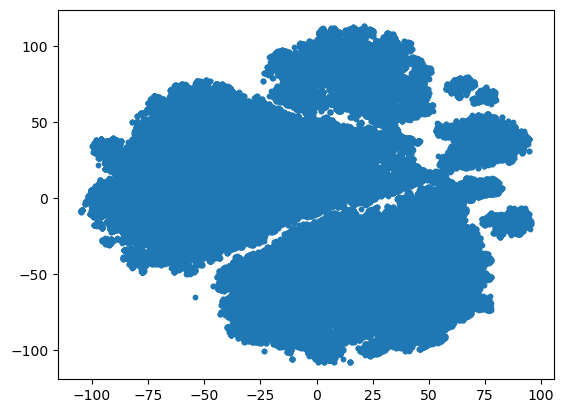

In [118]:
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s = 10)

In [119]:
inertia = []
silhouette = []
N = 15
for i in range(2, N):
    kmeans = KMeans(n_clusters=i, random_state=1).fit(df_cluster_2)
    preds = kmeans.predict(df_cluster_2)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_cluster_2, preds))

C:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

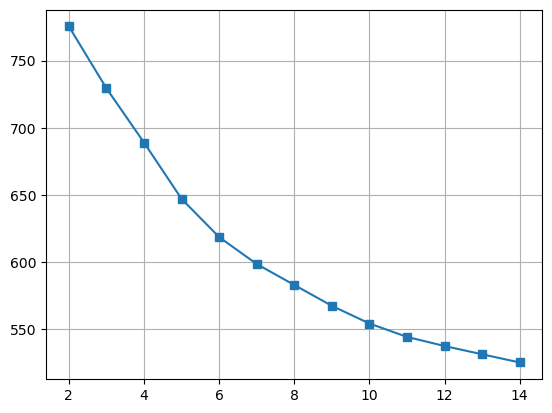

In [120]:
plt.plot(np.arange(2, N), inertia, marker = 's')
plt.grid()
plt.show()

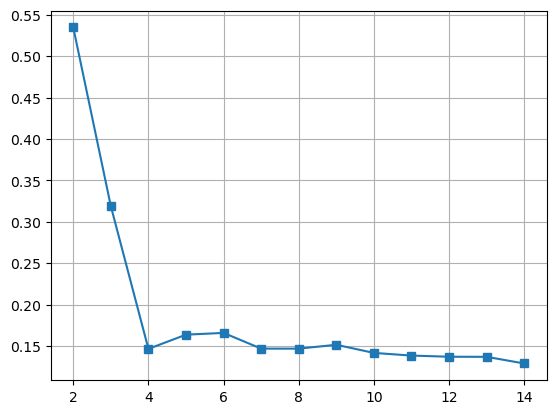

In [121]:
plt.plot(np.arange(2, N), silhouette, marker = 's')
plt.grid()
plt.show()

На графике silhouette-score видно, что оптимально разбиение на 4 кластера.

C:\Users\LEGION\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


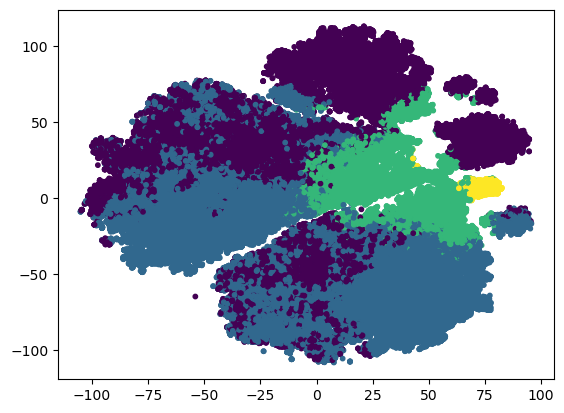

In [122]:
kmeans = KMeans(n_clusters=4).fit(df_cluster_2)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s = 10, c = kmeans.labels_)

На графике видно, что в общем объеме данных преобладают 2 кластера, а 1 кластер имеет значительно меньший объем.

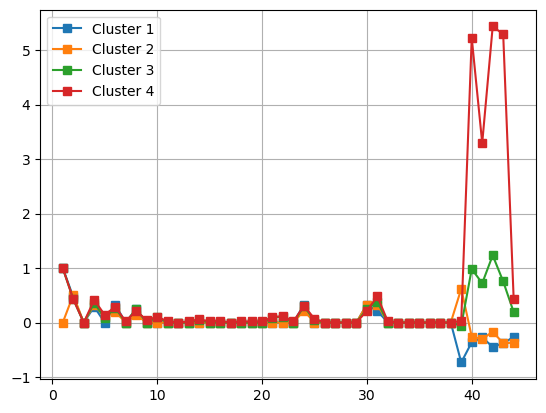

In [123]:
plt.plot(range(1, df_cluster_2.shape[1] + 1), np.median(df_cluster_2.values[kmeans.labels_ == 0, :], axis = 0), marker = 's', label = 'Cluster 1')
plt.plot(range(1, df_cluster_2.shape[1] + 1), np.median(df_cluster_2.values[kmeans.labels_ == 1, :], axis = 0), marker = 's', label = 'Cluster 2')
plt.plot(range(1, df_cluster_2.shape[1] + 1), np.median(df_cluster_2.values[kmeans.labels_ == 2, :], axis = 0), marker = 's', label = 'Cluster 3')
plt.plot(range(1, df_cluster_2.shape[1] + 1), np.median(df_cluster_2.values[kmeans.labels_ == 3, :], axis = 0), marker = 's', label = 'Cluster 4')
plt.legend()
plt.grid()
plt.show()

Исходя из графика видно, что 2 кластер отличаются от остальных по гендерному признаку (1 признак). Далее значения признаков в четырех кластерах близки. Затем, начиная с 39-го признака (39 – возраст, 40 – количество купленных товаров, 41 – выручка с покупателя, 42 – количество чеков, 43 – количество купленных товаров со скидкой, 44 – средний чек), видно значительное разделение кластеров. Так 4 кластер имеет очень высокие значения признаков, 3 кластер – умеренные, а 1 и 2 имеют отрицательные значения признаков, что может указывать на их противоположные характеристики относительно кластеров 3 и 4.

In [132]:
df_cluster['cluster'] = kmeans.labels_
cluster_stats = df_cluster.groupby('cluster').median()

In [138]:
cluster_stats[['gender', 'age', 'products_count', 'total_revenue', 'purchase_count', 'products_count_with_sale', 'avg_purchase_amount', 'discount_sensitivity']]

,gender,age,products_count,total_revenue,purchase_count,products_count_with_sale,avg_purchase_amount,discount_sensitivity
cluster,,,,,,,,
0,1.0,30.0,4.0,19958.0,3.0,1.0,5851.60,0.290
1,0.0,46.0,5.0,17597.0,4.0,1.0,4893.50,0.330
2,1.0,38.0,17.0,95097.0,9.0,6.0,10033.78,0.360
3,1.0,39.0,58.0,289701.0,24.0,26.0,12213.36,0.415


In [141]:
df_cluster.groupby('cluster').id.nunique()

cluster
0    41602
1    45709
2    13403
3      880
Name: id, dtype: int64

Видно, что к первому кластеру относятся преимущественно мужчины. Возраст этого кластера молодой. В этом кластере минимальное количество купленных товаров, в том числе и со скидкой, минимальное количество чеков и низкий средний чек. Соответственно, это малоактивные покупатели, имеющие слабую вовлеченность.\
Ко второму кластеру относятся преимущественно женщины старшего возраста. Количество покупок этого кластера немного выше, чем у первого, однако средний чек и выручка самые низкие. Этот кластер более чувствителен к скидке, чем первый. Соответственно, для данного кластера характерны экономные покупатели.\
К третьему кластеру относятся преимущественно мужчины. Для этого кластера характерны стабильные покупатели среднего возраста с хорошей частотой покупок и умеренным использованием акций. Они приносят значительную выручку, но не являются максимально прибыльными.\
К четвертому кластеру относятся преимущественно мужчины. Возраст данного кластера средний. Для этого кластера характерна высокая частота покупок, высокий средний чек и активное использование акций. Вероятно, к данному кластеру относятся лояльные покупатели и корпоративные клиенты.

In [142]:
df = pd.merge(df, df_cluster[['id', 'cluster']], on = 'id', how = 'left')

In [143]:
df

,id,gender,age,education,city,personal_coef,product,colour,cost,product_sex,base_sale,dt,normalized_colour,product_category,cluster
0,0,0.0,36,среднее,1201,0.5072,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0,1,7,"[белый, синий]",транспорт,0
1,0,0.0,36,среднее,1201,0.5072,Стол Outventure,зелёный,1499,3,0,37,[зеленый],туристические аксессуары,0
2,0,0.0,36,среднее,1201,0.5072,Набор Outventure: стол + 4 стула,бежевый,4799,3,0,37,[бежевый],туристические аксессуары,0
3,4,0.0,35,среднее,1134,0.5072,Роликовые коньки детские Roces Orlando III,черный/розовый,9199,2,0,0,"[черный, розовый]",транспорт,0
4,4,0.0,35,среднее,1134,0.5072,Шлем FILA NRK FUN,белый,4999,3,0,0,[белый],аксессуары для спорта,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761566,15885,1.0,33,среднее,1190,0.4304,Поло мужское Outventure,синий,1599,1,0,24,[синий],одежда,0
761567,15885,1.0,33,среднее,1190,0.4304,Майка мужская Babolat Complete Muscle,оранжевый/синий,3899,1,0,24,"[оранжевый, синий]",одежда,0
761568,15885,1.0,33,среднее,1190,0.4304,Майка мужская Protest Prtihiaka,белый/принт,1679,1,1,49,"[белый, другой]",одежда,0
761569,15885,1.0,33,среднее,1190,0.4304,Массажер Demix,темно-зелёный,399,3,0,52,[зеленый],"спортивное питание, медицина, красота",0


In [144]:
top_categories = df.groupby(['cluster', 'product_category']).size().groupby(level=0).nlargest(5).reset_index(level=0, drop=True).reset_index(name='count')

In [145]:
top_categories

,cluster,product_category,count
0,0,обувь,71282
1,0,одежда,66284
2,0,аксессуары,15376
3,0,туристические аксессуары,13322
4,0,рюкзаки и сумки,10407
5,1,одежда,94007
6,1,обувь,88028
7,1,аксессуары,17460
8,1,туристические аксессуары,11222
9,1,рюкзаки и сумки,10248


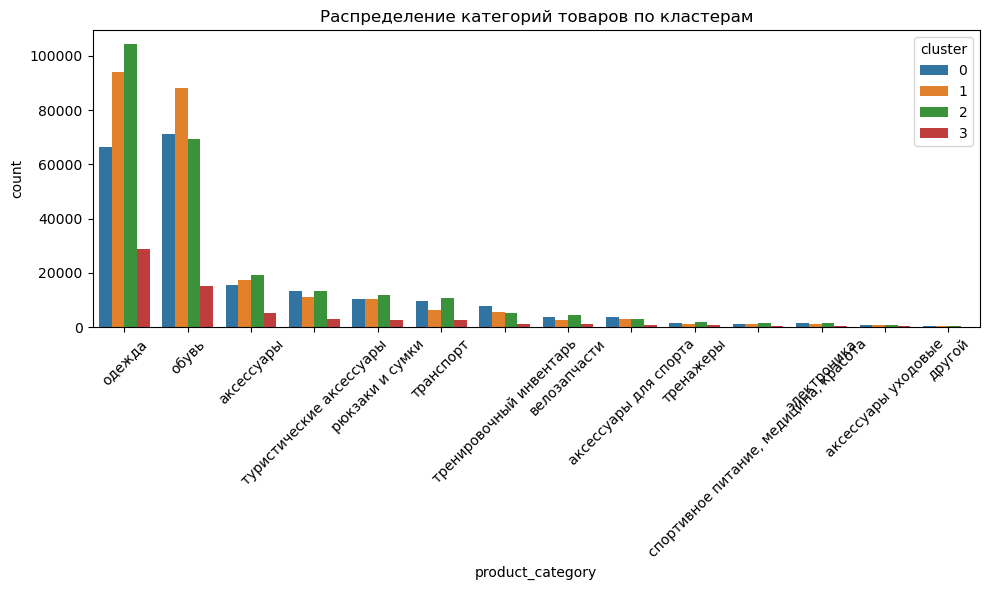

In [150]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='product_category', hue='cluster',
             order=df['product_category'].value_counts().index)
plt.title('Распределение категорий товаров по кластерам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

В качестве рекомендаций можно предложить:\
Для 1 кластера: скидки на вторую пару обуви, комплекты «обувь и уходовые аксессуары», акцент на мужские коллекции обуви.\
Для 2 кластера: скидки на базовый гардероб, наборы «платье и сумка», рассылка о новых коллекциях одежды.\
Для 3 кластера: бонусы за частые покупки, рекомендации «полный образ» (одежда, обувь и аксессуары), ранний доступ к новинкам.\
Для 4 кластера: скидки на крупные заказы, доступ к эксклюзивным коллекциям, подарки из категории велозапчасти при покупке транспорта.

# Построение модели склонности клиента к покупке

In [151]:
df_city = df[df['city'] == 1188]
df_city = pd.merge(df_city, df_cluster[['id', 'avg_purchase_amount', 'discount_sensitivity']], on = 'id', how = 'left')

## Модель склонности клиента к покупке аксессуаров для спорта

In [153]:
target_category = 'аксессуары для спорта'
df_city['target'] = (df_city['product_category'] == target_category).astype(int)

In [154]:
df_city[df_city['target'] == 1].shape

(1247, 18)

In [155]:
mlb = MultiLabelBinarizer()
colour_encoded = pd.DataFrame(
    mlb.fit_transform(df_city['normalized_colour']),
    columns=mlb.classes_,
    index=df_city.index
)

In [156]:
education_encoded = df_city['education'].map({'среднее': 0, 'высшее': 1})

In [157]:
df_processed = pd.concat([
    df_city.drop(columns=['colour', 'normalized_colour', 'product', 'product_category', 'education', 'city', 'dt']),
    colour_encoded,
    education_encoded
], axis=1)

In [158]:
X = df_processed.drop(columns=['target', 'id'])
y = df_processed['target']

In [159]:
numeric_features = ['age', 'cost', 'avg_purchase_amount']
categorical_features = ['gender', 'product_sex', 'base_sale', 'cluster']

In [160]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [161]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=15,
        random_state=42,
        class_weight='balanced'
    ))
])

In [162]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [163]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'cost',
                                                   'avg_purchase_amount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'product_sex',
                                                   'base_sale', 'cluster'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=15, n_estimators=200,
                                        random_state=42))])

In [164]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     17194
           1       0.06      0.91      0.12       244

    accuracy                           0.81     17438
   macro avg       0.53      0.86      0.51     17438
weighted avg       0.99      0.81      0.88     17438


ROC-AUC Score: 0.8582137402105575


In [165]:
#from sklearn.model_selection import GridSearchCV
#
#param_grid = {
#    'classifier__n_estimators': [50, 100, 200],
#    'classifier__max_depth': [None, 10, 20],
#    'classifier__min_samples_split': [2, 5, 10, 15],
#    'classifier__random_state': [42],
#    'classifier__class_weight': ['balanced']
#}
#
#grid_search = GridSearchCV(model, param_grid, cv=3, scoring = 'recall')
#grid_search.fit(X_train, y_train)
#print(f'Лучшие параметры: {grid_search.best_params_}')

Лучшие параметры: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 200, 'classifier__random_state': 42}

In [166]:
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=0.01,
        penalty='l2',
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    ))
])

In [167]:
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'cost',
                                                   'avg_purchase_amount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'product_sex',
                                                   'base_sale', 'cluster'])])),
                ('classifier',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [168]:
y_pred_logistic = logistic_pipeline.predict(X_test)
y_proba_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

In [169]:
print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logistic))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_proba_logistic))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86     17194
           1       0.05      0.93      0.10       244

    accuracy                           0.75     17438
   macro avg       0.52      0.84      0.48     17438
weighted avg       0.99      0.75      0.85     17438


ROC-AUC Score: 0.8908056470328002


In [170]:
#param_grid = {
#    'classifier__C': [0.01, 0.1, 1, 10],
#    'classifier__penalty': ['l1', 'l2'],
#    'classifier__random_state': [42],
#    'classifier__class_weight': ['balanced'],
#    'classifier__max_iter': [1000],
#    'classifier__solver': ['liblinear', 'saga']
#}

#logistic_grid = GridSearchCV(logistic_pipeline, param_grid, cv=3, scoring = 'recall')
#logistic_grid.fit(X_train, y_train)
#print(f'Лучшие параметры: {logistic_grid.best_params_}')

Лучшие параметры: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__random_state': 42, 'classifier__solver': 'liblinear'}

Модель LogisticRegression верно предсказала класс 1 с большей долей, чем модель RandomForestClassifier, однако и было больше ошибочных предсказаний этого класса. То есть модель чаще прогнозирует класс «купит».

## Модель склонности клиента к покупке аксессуаров

In [171]:
target_category = 'аксессуары'
df_city['target'] = (df_city['product_category'] == target_category).astype(int)

print(df_city[df_city['target'] == 1].shape)

df_processed = pd.concat([
    df_city.drop(columns=['colour', 'normalized_colour', 'product', 'product_category', 'education', 'city']),
    colour_encoded,
    education_encoded
], axis=1)

X = df_processed.drop(columns=['target', 'id'])
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logistic_pipeline.fit(X_train, y_train)

y_pred_logistic = logistic_pipeline.predict(X_test)
y_proba_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logistic))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_proba_logistic))

(6674, 18)
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     16127
           1       0.24      0.82      0.37      1311

    accuracy                           0.79     17438
   macro avg       0.61      0.81      0.63     17438
weighted avg       0.93      0.79      0.84     17438


ROC-AUC Score: 0.8662517487882344


In [172]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88     16127
           1       0.26      0.91      0.41      1311

    accuracy                           0.80     17438
   macro avg       0.63      0.85      0.65     17438
weighted avg       0.94      0.80      0.85     17438


ROC-AUC Score: 0.8502182831100793


## Модель склонности клиента к покупке туристических аксессуаров

In [173]:
target_category = 'туристические аксессуары'
df_city['target'] = (df_city['product_category'] == target_category).astype(int)

print(df_city[df_city['target'] == 1].shape)

df_processed = pd.concat([
    df_city.drop(columns=['colour', 'normalized_colour', 'product', 'product_category', 'education', 'city']),
    colour_encoded,
    education_encoded
], axis=1)

X = df_processed.drop(columns=['target', 'id'])
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logistic_pipeline.fit(X_train, y_train)

y_pred_logistic = logistic_pipeline.predict(X_test)
y_proba_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logistic))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_proba_logistic))

(4803, 18)
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.87     16485
           1       0.19      0.97      0.32       953

    accuracy                           0.78     17438
   macro avg       0.59      0.87      0.59     17438
weighted avg       0.95      0.78      0.84     17438


ROC-AUC Score: 0.9307804067483524


In [174]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88     16485
           1       0.21      0.98      0.35       953

    accuracy                           0.80     17438
   macro avg       0.60      0.88      0.61     17438
weighted avg       0.96      0.80      0.85     17438


ROC-AUC Score: 0.8840047281369022


## Модель склонности клиента к покупке рюкзаков и сумок

In [175]:
target_category = 'рюкзаки и сумки'
df_city['target'] = (df_city['product_category'] == target_category).astype(int)

print(df_city[df_city['target'] == 1].shape)

df_processed = pd.concat([
    df_city.drop(columns=['colour', 'normalized_colour', 'product', 'product_category', 'education', 'city']),
    colour_encoded,
    education_encoded
], axis=1)

X = df_processed.drop(columns=['target', 'id'])
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logistic_pipeline.fit(X_train, y_train)

y_pred_logistic = logistic_pipeline.predict(X_test)
y_proba_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logistic))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_proba_logistic))

(4113, 18)
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     16569
           1       0.18      0.94      0.31       869

    accuracy                           0.79     17438
   macro avg       0.59      0.86      0.59     17438
weighted avg       0.96      0.79      0.85     17438


ROC-AUC Score: 0.9020254664717291


In [176]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     16569
           1       0.20      0.94      0.33       869

    accuracy                           0.81     17438
   macro avg       0.60      0.87      0.61     17438
weighted avg       0.96      0.81      0.86     17438


ROC-AUC Score: 0.8700423260513745


## Модель склонности клиента к покупке транспорта

In [177]:
target_category = 'транспорт'
df_city['target'] = (df_city['product_category'] == target_category).astype(int)

print(df_city[df_city['target'] == 1].shape)

df_processed = pd.concat([
    df_city.drop(columns=['colour', 'normalized_colour', 'product', 'product_category', 'education', 'city']),
    colour_encoded,
    education_encoded
], axis=1)

X = df_processed.drop(columns=['target', 'id'])
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logistic_pipeline.fit(X_train, y_train)

y_pred_logistic = logistic_pipeline.predict(X_test)
y_proba_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logistic))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_proba_logistic))

(3304, 18)
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     16763
           1       0.32      0.86      0.47       675

    accuracy                           0.92     17438
   macro avg       0.66      0.90      0.71     17438
weighted avg       0.97      0.92      0.94     17438


ROC-AUC Score: 0.9651924763754387


In [178]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     16763
           1       0.44      0.88      0.58       675

    accuracy                           0.95     17438
   macro avg       0.72      0.92      0.78     17438
weighted avg       0.97      0.95      0.96     17438


ROC-AUC Score: 0.917743663845197


## Модель склонности клиента к покупке тренировочного инвентаря

In [179]:
target_category = 'тренировочный инвентарь'
df_city['target'] = (df_city['product_category'] == target_category).astype(int)

print(df_city[df_city['target'] == 1].shape)

df_processed = pd.concat([
    df_city.drop(columns=['colour', 'normalized_colour', 'product', 'product_category', 'education', 'city']),
    colour_encoded,
    education_encoded
], axis=1)

X = df_processed.drop(columns=['target', 'id'])
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logistic_pipeline.fit(X_train, y_train)

y_pred_logistic = logistic_pipeline.predict(X_test)
y_proba_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logistic))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_proba_logistic))

(2143, 18)
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     17016
           1       0.09      0.98      0.17       422

    accuracy                           0.76     17438
   macro avg       0.54      0.87      0.51     17438
weighted avg       0.98      0.76      0.84     17438


ROC-AUC Score: 0.915043020563863


In [180]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     17016
           1       0.10      0.97      0.19       422

    accuracy                           0.80     17438
   macro avg       0.55      0.88      0.54     17438
weighted avg       0.98      0.80      0.87     17438


ROC-AUC Score: 0.8811556226980127


## Модель склонности клиента к покупке велозапчастей

In [181]:
target_category = 'велозапчасти'
df_city['target'] = (df_city['product_category'] == target_category).astype(int)

print(df_city[df_city['target'] == 1].shape)

df_processed = pd.concat([
    df_city.drop(columns=['colour', 'normalized_colour', 'product', 'product_category', 'education', 'city']),
    colour_encoded,
    education_encoded
], axis=1)

X = df_processed.drop(columns=['target', 'id'])
y = df_processed['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logistic_pipeline.fit(X_train, y_train)

y_pred_logistic = logistic_pipeline.predict(X_test)
y_proba_logistic = logistic_pipeline.predict_proba(X_test)[:, 1]

print('Logistic Regression Classification Report:')
print(classification_report(y_test, y_pred_logistic))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_proba_logistic))

(1288, 18)
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     17181
           1       0.07      0.94      0.14       257

    accuracy                           0.82     17438
   macro avg       0.54      0.88      0.52     17438
weighted avg       0.99      0.82      0.89     17438


ROC-AUC Score: 0.9386331204250827


In [182]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print('\nROC-AUC Score:', roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     17181
           1       0.10      0.91      0.18       257

    accuracy                           0.88     17438
   macro avg       0.55      0.90      0.56     17438
weighted avg       0.99      0.88      0.92     17438


ROC-AUC Score: 0.8971029892988748


Для более часто встречаемых товаров модель RandomForestClassifier показывает лучше результаты, относительно модели LogisticRegression.

В результате можно сказать, что обе модели имеют достаточно большую долю верно спрогнозированных классов «купит» среди класса «купит», однако ценой большого числа ложных срабатываний, что связано с сильным дисбалансом классов.\
На мой взгляд модели можно использовать, например, для рассылки промокодов на определенные товары или других рекламных акций, однако предварительно следует оценить целесообразность с точки зрения затрат и ожидаемой прибыли.